In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from scipy.optimize import fsolve
from scipy.stats import binom
from math import isclose

In [2]:
infol = '/Users/irffanalahi/Research/Research_update/in-silico/Rdresult/corrmNeuallrange/v4_1000000_differentPhred/5g_diffphred/cpg3'
infiles = os.listdir(infol)

if '.ipynb_checkpoints' in infiles:
    infiles.remove('.ipynb_checkpoints')
    
if '.DS_Store' in infiles:
    infiles.remove('.DS_Store')

num_groups = 3
num_samples = 1
num_lines = 54

probs = [0.5, 0.6, 0.7, 0.8, 0.9]  
    
cell = 'mNeu'
cell_real = 'mNeu_real'

#adj = 0.95
#out = 'multi_reporters.pdf'

r1 = [(45, '')]
min_reporters = [1, 6, 10, 20]
d1 = 30

In [3]:
x_lists = []
y_lists = []
for i in range(len(infiles)):
    file_name = infiles[i]
    file = infol + '/' + file_name
    data = pd.read_csv(file, sep='\t', index_col=0)
    df = pd.DataFrame(data)
    
    x = []
    y = []
    num_samples = int(len(df) / num_lines)
    for j in range(num_samples):
        df_subset = df[num_lines*j:num_lines*(j+1)].copy()
        
        df_subset['Index Number'] = [int(i.split('insilmix')[-1]) for i in df_subset.index]

        df_subset.sort_values(['Index Number'], inplace=True)
        df_subset = df_subset.drop('Index Number', axis=1)
    
        for col in df.columns:
            if 'real' not in col:
                df_subset[col] = np.array(df_subset[col]) * 100

        x += list(df_subset[cell_real])
        y += list(df_subset[cell])
    
    x_lists.append((file_name, list(x)))
    y_lists.append((file_name, list(y)))

In [4]:
outfol = infol + '_probability'
os.mkdir(outfol)

for k in range(len(x_lists)):
    tpl = x_lists[k]
    tpl_y = y_lists[k]
    f1 = np.array(tpl[1])
    f2 = np.array(tpl_y[1])
    df_out = pd.DataFrame()
    df_out[cell_real] = f1
    df_out[cell] = f2

    for j in range(len(min_reporters)):
        for i in range(len(r1)):
            prob = 1 - binom.cdf(min_reporters[j] - 1, d1 * r1[i][0], f1 / 100)
            df_out['Probability | Min Reporters: ' + str(min_reporters[j])] = prob
            new_frac = np.multiply(prob, np.array(tpl[1]))
            df_out[cell_real + ' | Min Reporters: ' + str(min_reporters[j])] = new_frac

    df_out.to_csv(outfol + '/' + tpl[0], sep='\t', index=False)

In [5]:
infol_prob = outfol
infiles_prob = os.listdir(infol)
    
if '.ipynb_checkpoints' in infiles_prob:
    infiles_prob.remove('.ipynb_checkpoints')
    
if '.DS_Store' in infiles_prob:
    infiles_prob.remove('.DS_Store')
    
print(infiles_prob)

['phred=30', 'phred=40', 'phred=0', 'phred=20']


In [6]:
def generate_lists(df, cell_name, cell_name_real):
    num = 0
    avg_vals_real = []
    avg_vals = []
    avg_lst_real = np.zeros(num_groups)
    avg_lst = np.zeros(num_groups)

    mNeu_arr = np.array(df[cell_name])
    mNeu_arr_real = np.array(df[cell_name_real])
    for i in range(len(df)):
        if num == num_groups:
            avg_vals.append(np.mean(avg_lst))
            avg_vals_real.append(np.mean(avg_lst_real))
            avg_lst_real = np.zeros(num_groups)
            avg_lst = np.zeros(num_groups)
            num = 0
        avg_lst[num] = mNeu_arr[i]
        avg_lst_real[num] = mNeu_arr_real[i]
        num += 1
    
    avg_vals.append(np.mean(avg_lst))
    avg_vals_real.append(np.mean(avg_lst_real))

    return avg_vals, avg_vals_real

In [7]:
file_name = infiles_prob[0]
file = infol_prob + '/' + file_name
data = pd.read_csv(file, sep='\t')
df = pd.DataFrame(data)

col_probs = []
col_mNeu = []

for col in df.columns:
    if 'Probability' in col:
        col_probs.append(col)
    if 'mNeu_real |' in col:
        col_mNeu.append(col)
        
def closest(lst, K):
    return lst[min(range(len(lst)), key = lambda i: abs(lst[i]-K))]

here


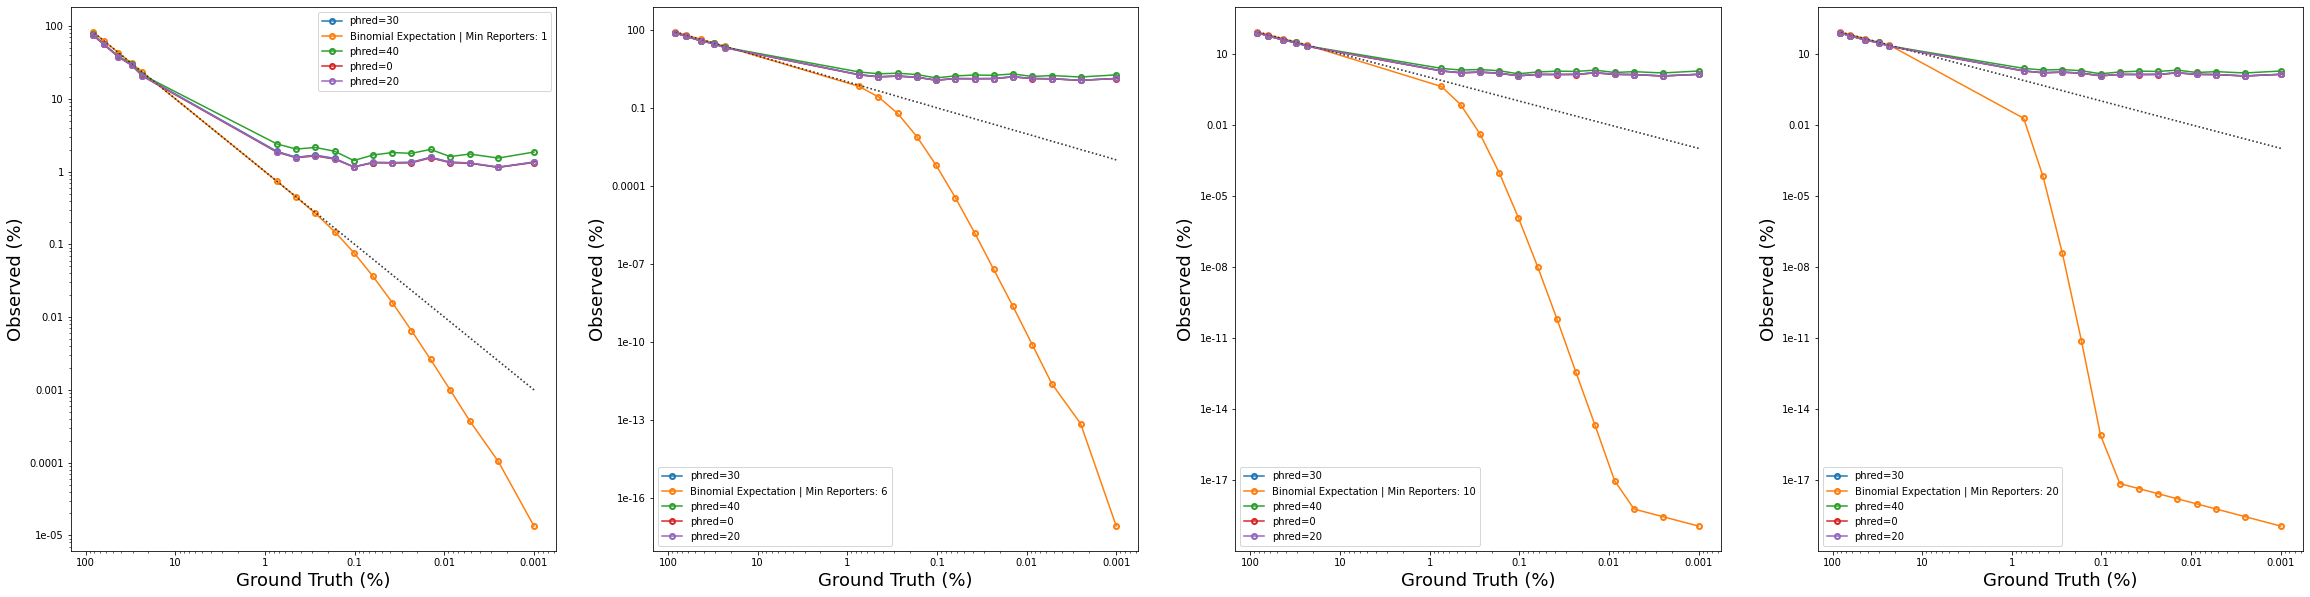

In [8]:
fig, axs = plt.subplots(1, len(col_mNeu), figsize=(10 * len(col_mNeu), 10))

color=plt.cm.rainbow(np.linspace(0,1,len(infiles)))
print('here')
for i in range(len(infiles)):
    '''
    file_name = infiles[i]
    file = infol + '/' + file_name
    data = pd.read_csv(file, sep='\t')
    df = pd.DataFrame(data)
    display(df)
    '''
    
    file_name = infiles_prob[i]
    file = infol_prob + '/' + file_name
    data = pd.read_csv(file, sep='\t')
    df = pd.DataFrame(data)
    # '''
    
    used_probs = []
    
    for k in range(len(col_mNeu)):
        x = []
        y = []
        
        x1 = []
        y1 = []
        for j in range(num_samples):
            df_subset = df[num_lines*j:num_lines*(j+1)].copy()
        
            '''
            for col in df.columns:
                if ('real' not in col) and ('mNeu' in col):
                    df_subset[col] = np.array(df_subset[col]) * 100
            '''
            
            x1 += generate_lists(df_subset, cell, cell_real)[1]
            y1 += generate_lists(df_subset, cell, cell_real)[0]
            
            x += generate_lists(df_subset, col_mNeu[k], cell_real)[1]
            y += generate_lists(df_subset, col_mNeu[k], cell_real)[0]

        # c = color[i]
        x, y = zip(*sorted(zip(x, y)))
        x1, y1 = zip(*sorted(zip(x1, y1)))
        if i == 1:
            axs[k].plot(x, y, label='Binomial Expectation | ' + col_mNeu[k].split(' | ')[1], marker='o', mew=2, ms=5, fillstyle='none')
        axs[k].plot(x1, y1, label=file_name, marker='o', mew=2, ms=5, fillstyle='none')
        axs[k].plot(x, x, alpha=0.3, ls=':', c='k')
        # axs[k].set_title(col_mNeu[k].split(' | ')[1], fontsize=20)
        
        prob_lst = list(df_subset[col_probs[k]])
        
        '''
        if i == 0:
            for prob in probs:
                val = closest(prob_lst, prob)
                if np.around(val, decimals=2) not in used_probs:
                    mNeu_val = float(df_subset[df_subset[col_probs[k]] == val][col_mNeu[k]])
                    axs[k].plot([mNeu_val] * len(y), y, label='Probability = ' + str(np.around(val, decimals=4)), ls=':')
                    used_probs.append(np.around(val, decimals=2))
        '''
            
        axs[k].set_xscale('log')
        axs[k].set_yscale('log')
        axs[k].set_xlabel('Ground Truth (%)', fontsize=18)
        axs[k].set_ylabel('Observed (%)', fontsize=18)
        axs[k].xaxis.set_major_formatter(mtick.FuncFormatter(lambda y, _: '{:g}'.format(y)))
        axs[k].yaxis.set_major_formatter(mtick.FuncFormatter(lambda y, _: '{:g}'.format(y)))
        axs[k].legend()
        
for r in range(len(col_mNeu)):
    axs[r].invert_xaxis()

In [9]:
fig.savefig(infol+'_plot_g_test_gtvsreal.pdf',dpi=300, bbox_inches='tight')

here


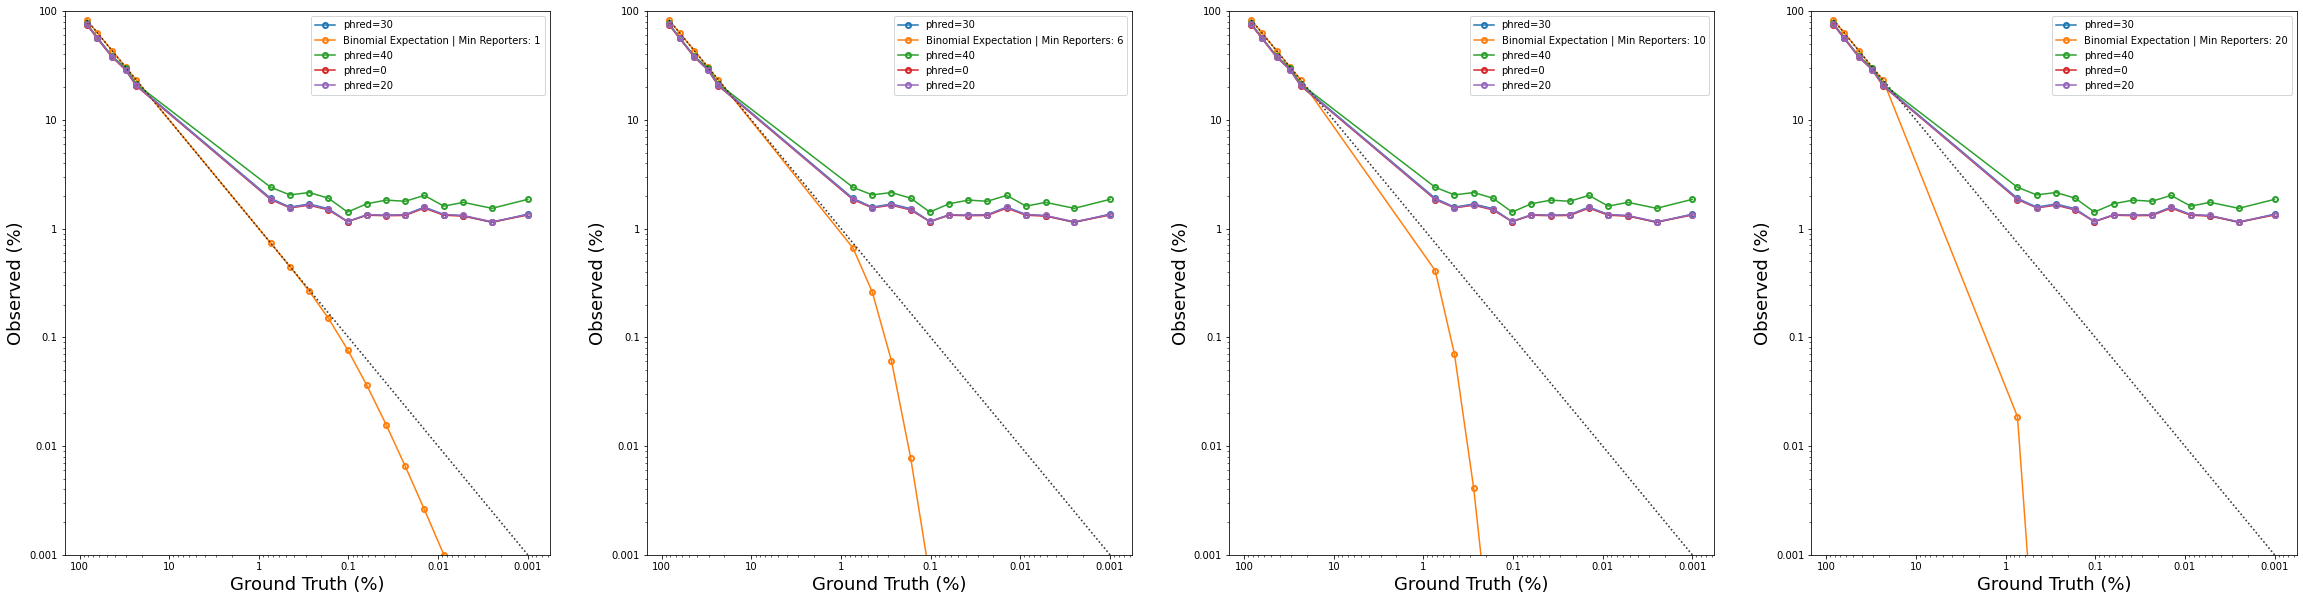

In [10]:
fig, axs = plt.subplots(1, len(col_mNeu), figsize=(10 * len(col_mNeu), 10))

color=plt.cm.rainbow(np.linspace(0,1,len(infiles)))
print('here')
for i in range(len(infiles)):
    '''
    file_name = infiles[i]
    file = infol + '/' + file_name
    data = pd.read_csv(file, sep='\t')
    df = pd.DataFrame(data)
    display(df)
    '''
    
    file_name = infiles_prob[i]
    file = infol_prob + '/' + file_name
    data = pd.read_csv(file, sep='\t')
    df = pd.DataFrame(data)
    # '''
    
    used_probs = []
    
    for k in range(len(col_mNeu)):
        x = []
        y = []
        
        x1 = []
        y1 = []
        for j in range(num_samples):
            df_subset = df[num_lines*j:num_lines*(j+1)].copy()
        
            '''
            for col in df.columns:
                if ('real' not in col) and ('mNeu' in col):
                    df_subset[col] = np.array(df_subset[col]) * 100
            '''
            
            x1 += generate_lists(df_subset, cell, cell_real)[1]
            y1 += generate_lists(df_subset, cell, cell_real)[0]
            
            x += generate_lists(df_subset, col_mNeu[k], cell_real)[1]
            y += generate_lists(df_subset, col_mNeu[k], cell_real)[0]

        # c = color[i]
        x, y = zip(*sorted(zip(x, y)))
        x1, y1 = zip(*sorted(zip(x1, y1)))
        if i == 1:
            axs[k].plot(x, y, label='Binomial Expectation | ' + col_mNeu[k].split(' | ')[1], marker='o', mew=2, ms=5, fillstyle='none')
        axs[k].plot(x1, y1, label=file_name, marker='o', mew=2, ms=5, fillstyle='none')
        axs[k].plot(x, x, alpha=0.3, ls=':', c='k')
        # axs[k].set_title(col_mNeu[k].split(' | ')[1], fontsize=20)
        
        prob_lst = list(df_subset[col_probs[k]])
        
        '''
        if i == 0:
            for prob in probs:
                val = closest(prob_lst, prob)
                if np.around(val, decimals=2) not in used_probs:
                    mNeu_val = float(df_subset[df_subset[col_probs[k]] == val][col_mNeu[k]])
                    axs[k].plot([mNeu_val] * len(y), y, label='Probability = ' + str(np.around(val, decimals=4)), ls=':')
                    used_probs.append(np.around(val, decimals=2))
        '''
            
        axs[k].set_xscale('log')
        axs[k].set_yscale('log')
        axs[k].set_xlabel('Ground Truth (%)', fontsize=18)
        axs[k].set_ylabel('Observed (%)', fontsize=18)
        axs[k].xaxis.set_major_formatter(mtick.FuncFormatter(lambda y, _: '{:g}'.format(y)))
        axs[k].yaxis.set_major_formatter(mtick.FuncFormatter(lambda y, _: '{:g}'.format(y)))
        axs[k].set_ylim(0.001, 100)
        axs[k].legend()
        
for r in range(len(col_mNeu)):
    axs[r].invert_xaxis()

In [11]:
fig.savefig(infol+'_plot_g_test_gtvsreal_adjustedylim.pdf',dpi=300, bbox_inches='tight')

here


TypeError: cannot convert the series to <class 'float'>

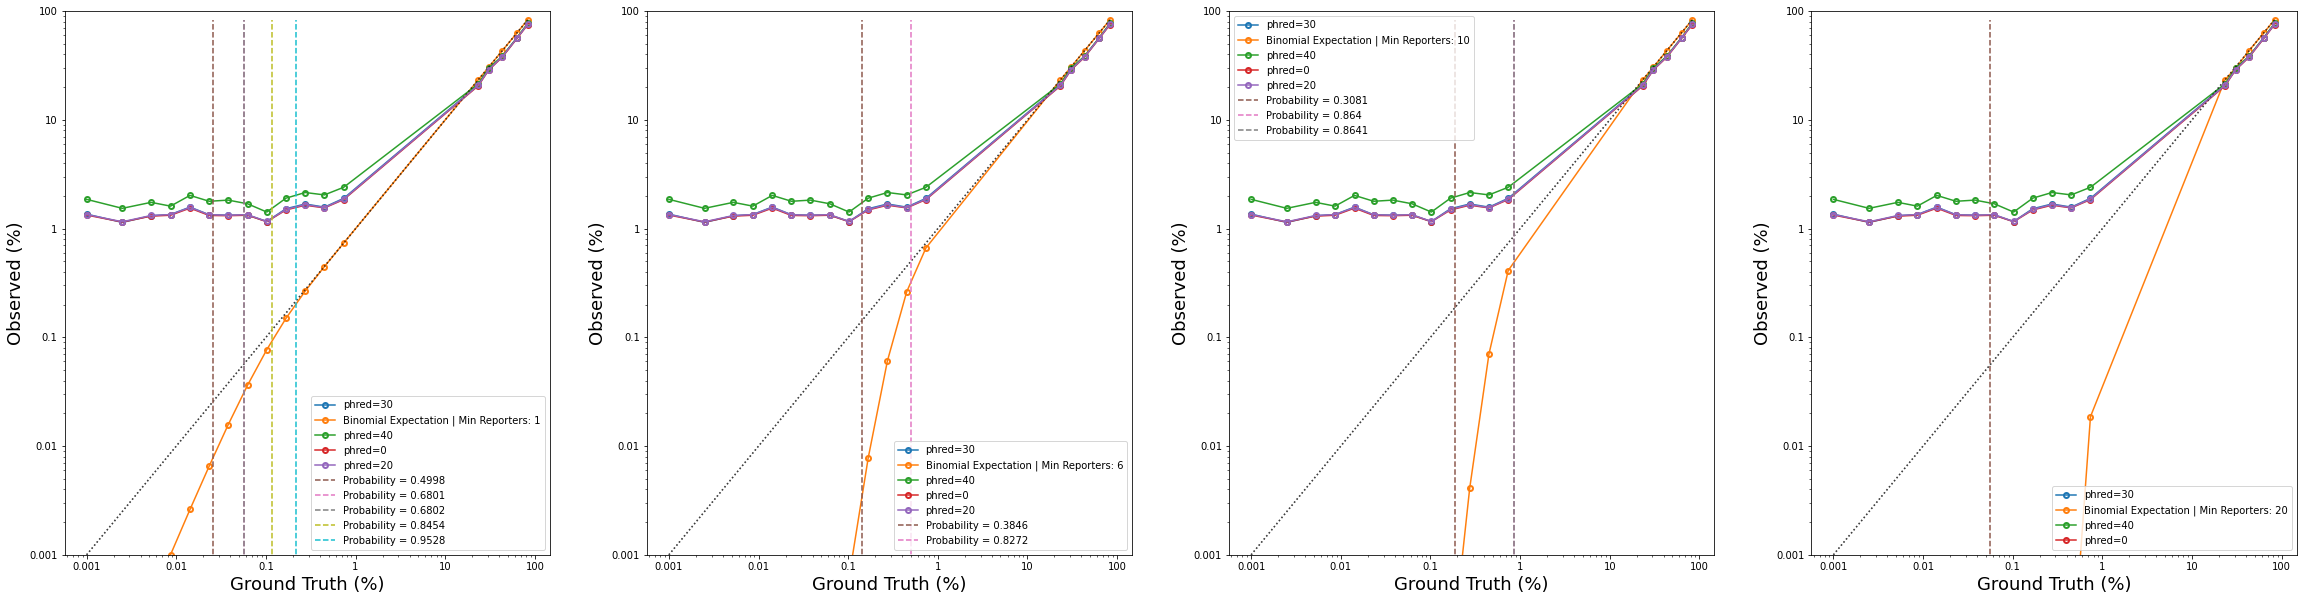

In [12]:
fig, axs = plt.subplots(1, len(col_mNeu), figsize=(10 * len(col_mNeu), 10))

color=plt.cm.rainbow(np.linspace(0,1,len(infiles)))
print('here')
for i in range(len(infiles)):
    '''
    file_name = infiles[i]
    file = infol + '/' + file_name
    data = pd.read_csv(file, sep='\t')
    df = pd.DataFrame(data)
    display(df)
    '''
    
    file_name = infiles_prob[i]
    file = infol_prob + '/' + file_name
    data = pd.read_csv(file, sep='\t')
    df = pd.DataFrame(data)
    # '''
    
    for k in range(len(col_mNeu)):
        x = []
        y = []
        
        x1 = []
        y1 = []
        
        used_probs = []
        for j in range(num_samples):
            df_subset = df[num_lines*j:num_lines*(j+1)].copy()
        
            '''
            for col in df.columns:
                if ('real' not in col) and ('mNeu' in col):
                    df_subset[col] = np.array(df_subset[col]) * 100
            '''
            
            x1 += generate_lists(df_subset, cell, cell_real)[1]
            y1 += generate_lists(df_subset, cell, cell_real)[0]
            
            x += generate_lists(df_subset, col_mNeu[k], cell_real)[1]
            y += generate_lists(df_subset, col_mNeu[k], cell_real)[0]

        # c = color[i]
        x, y = zip(*sorted(zip(x, y)))
        x1, y1 = zip(*sorted(zip(x1, y1)))
        if i == 1:
            axs[k].plot(x, y, label='Binomial Expectation | ' + col_mNeu[k].split(' | ')[1], marker='o', mew=2, ms=5, fillstyle='none')
        axs[k].plot(x1, y1, label=file_name, marker='o', mew=2, ms=5, fillstyle='none')
        axs[k].plot(x, x, alpha=0.3, ls=':', c='k')
        # axs[k].set_title(col_mNeu[k].split(' | ')[1], fontsize=20)
        
        prob_lst = list(df[col_probs[k]])
        
        if i == len(infiles) - 1:
            for prob in probs:
                val = closest(prob_lst, prob)
                if np.around(val, decimals=4) not in used_probs:
                    mNeu_val = float(df[df[col_probs[k]] == val][col_mNeu[k]])
                    axs[k].plot([mNeu_val] * len(y), y, label='Probability = ' + str(np.around(val, decimals=4)), ls='--')
                    used_probs.append(np.around(val, decimals=4))
            
        axs[k].set_xscale('log')
        axs[k].set_yscale('log')
        axs[k].set_xlabel('Ground Truth (%)', fontsize=18)
        axs[k].set_ylabel('Observed (%)', fontsize=18)
        axs[k].xaxis.set_major_formatter(mtick.FuncFormatter(lambda y, _: '{:g}'.format(y)))
        axs[k].yaxis.set_major_formatter(mtick.FuncFormatter(lambda y, _: '{:g}'.format(y)))
        axs[k].set_ylim(0.001, 100)
        axs[k].legend()
        
for r in range(len(col_mNeu)):
    axs[r].invert_xaxis()

In [ ]:
fig.savefig(infol+'_plot_g_test_gtvsreal_adjustedylim_problines.pdf',dpi=300, bbox_inches='tight')